## Disaster Detector

Practicing deep learning for NLP by creating a text classificaiton model to predict whether a social media post is about a real disaster or not (a [Kaggle "Getting Started" competition](https://www.kaggle.com/competitions/nlp-getting-started/overview)).

### Data Exploration

Being curious and inspecting everything closely, creating exploratory visualizations.  Based on what is found, adjust data processing and feature engineering accordingly.

Observations:
  - Text is all in English.
  - Keyword is only missing <1% of the time, but it's not something that would be there in the real world... excluding from predictive model because of this, but still exploring for intuitive insights.
  - Location is missing about 1/3rd of the time. Excluding from model to focus purely on text.
  - Tweets about disasters tend to be longer
  - Some of the more colorful language in keywords are much less likely to be real disasters (e.g. hellfire, armageddon, body bags)
  - Location is not standardized.  Lots of variations of the same thing that have fairly significant differences in rates of being a real disaster (e.g. "worldwide" and "everywhere"... "United Kingdom" and "UK").

In [1]:
!pip install -q datasets evaluate

In [2]:
import re
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import evaluate
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import  AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

sys.path.append("nlp")
import preprocess
import tf_model



In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f'Training Set Shape = {train_df.shape}')
print(f'Test Set Shape = {test_df.shape}')

train_df

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
train_missing_keyword = pd.isna(train_df['keyword'])
test_missing_keyword  = pd.isna( test_df['keyword'])
train_missing_location = pd.isna(train_df['location'])
test_missing_location  = pd.isna(test_df['location'])
train_missing_keyword_location = train_missing_keyword | train_missing_location
test_missing_keyword_location  = test_missing_keyword  | test_missing_location


print(f"""% with missing keywords:
   Training: {np.round(np.mean(train_missing_keyword)*100,2)}% (n={np.sum(train_missing_keyword)})
   Test: {np.round(np.mean(test_missing_keyword)*100,2)}% (n={np.sum(test_missing_keyword)})

% of rows with missing keywords or locations:
   Training: {np.round(np.mean(train_missing_keyword_location)*100,2)}% (n={np.sum(train_missing_keyword_location)})
   Test: {np.round(np.mean(test_missing_keyword_location)*100,2)}% (n={np.sum(test_missing_keyword_location)})

% with missing locations:
   Training: {np.round(np.mean(train_missing_location)*100,2)}% (n={np.sum(train_missing_location)})
   Test: {np.round(np.mean(test_missing_location)*100,2)}% (n={np.sum(test_missing_location)})
   """)

% with missing keywords:
   Training: 0.8% (n=61)
   Test: 0.8% (n=26)

% of rows with missing keywords or locations:
   Training: 33.27% (n=2533)
   Test: 33.86% (n=1105)

% with missing locations:
   Training: 33.27% (n=2533)
   Test: 33.86% (n=1105)
   


In [5]:
### How long are the tweets?  Any differences in those that are about real disasters vs. not?
train_df["length"] = train_df["text"].apply(len)
test_df["length"] = test_df["text"].apply(len)

print("Train Length Stats:")
print(train_df["length"].describe())

print("\nTest Length Stats:")
print(test_df["length"].describe())

train_df.groupby('target').agg({'length': ["mean", "min", "max", "median"]})

Train Length Stats:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stats:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


length                
              mean min  max median
target                            
0        95.706817   7  157  101.0
1       108.113421  14  151  115.0

<Axes: ylabel='keyword'>

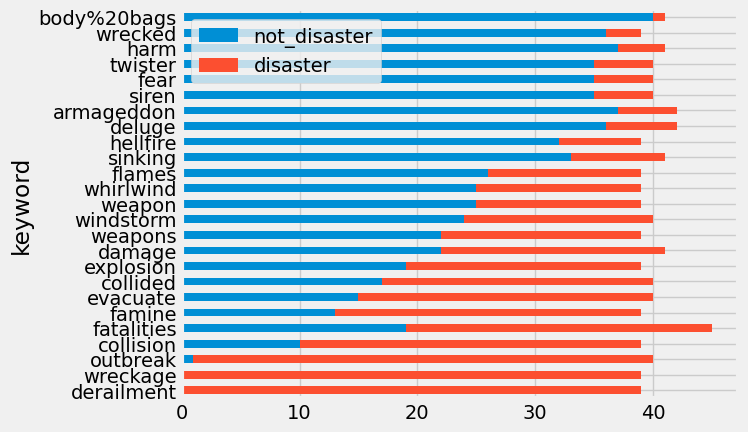

In [6]:
## Top keywords and how often they are disaster vs. not
plt.style.use('fivethirtyeight')
top_train_keywords = train_df.keyword.value_counts().head(25)
viz_df = train_df[train_df['keyword'].isin(top_train_keywords.index)].copy()
viz_df['disaster']     = viz_df['target'].apply(lambda x: 1 if x == 1 else 0)
viz_df['not_disaster'] = viz_df['target'].apply(lambda x: 1 if x == 0 else 0)
viz_df.groupby('keyword').agg({'not_disaster': 'sum', 'disaster': 'sum'}).sort_values('disaster', ascending=False).plot.barh(stacked=True)

<Axes: ylabel='location'>

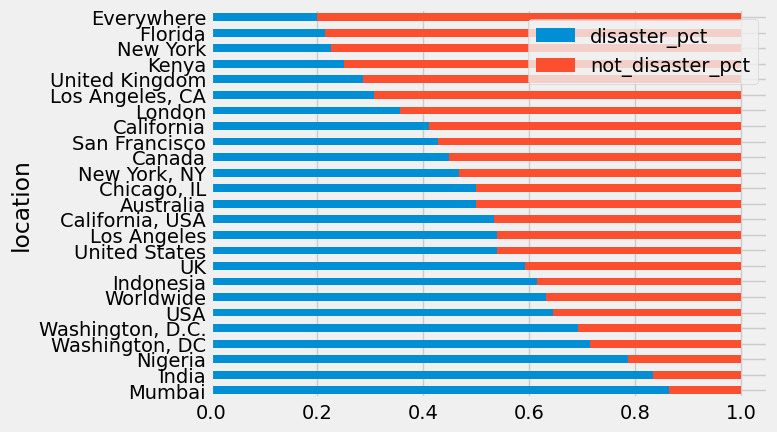

In [7]:
top_train_locations = train_df.location.value_counts().head(25)
viz_df = train_df[train_df['location'].isin(top_train_locations.index)].copy()
viz_df['disaster']     = viz_df['target'].apply(lambda x: 1 if x == 1 else 0)
viz_df['not_disaster'] = viz_df['target'].apply(lambda x: 1 if x == 0 else 0)
viz_grouped_df = viz_df.groupby('location').agg({'not_disaster': 'sum', 'disaster': 'sum'})
viz_grouped_df['disaster_pct'] = viz_grouped_df['disaster']/(viz_grouped_df['disaster']+viz_grouped_df['not_disaster'])
viz_grouped_df['not_disaster_pct'] = viz_grouped_df['not_disaster']/(viz_grouped_df['disaster']+viz_grouped_df['not_disaster'])
viz_grouped_df = viz_grouped_df.drop(columns=['disaster', 'not_disaster'])
viz_grouped_df.sort_values('disaster_pct', ascending=False).plot.barh(stacked=True)

### Model Experimentation & Evaluation

Compare the following models:
  - Fine-tuned DistilBERT (a small, fast, cheap and light Transformer model trained by distilling BERT base)
  - Custom "made-from-scratch" transformer model trained only on this dataset
    - Note: I'm expecting this to be massively overfit because the dataset is small (only ~7.5K training examples and transformers have a TON of parameters to optimize), but just doing this for the practice


TODO: Experiment with other model types (LSTM, xgboost, etc.) and architectures.

### Fine Tuned DistilBERT

Using HuggingFace 🤗 libraries to adapt

In [8]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # Define which pre-trained model we will be using
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # Get the classifier
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # Get the tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
train_hf_df, eval_hf_df = train_test_split(train_df, train_size=0.8,stratify=train_df['target'], random_state=42) # Stratified splitting

Compile data into HuggingFace dataset dictionaries.

In [10]:
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_hf_df),
    "eval": Dataset.from_pandas(eval_hf_df)
})

Pre-process text: tokenize and remove/rename columns.

In [11]:
tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text", "id"])
tokenized_datasets = tokenized_datasets.rename_column("target", "labels")

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [12]:
# Padding for batch of data that will be fed into model for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training args
training_args = TrainingArguments("test-trainer", num_train_epochs=1, evaluation_strategy="epoch",
                                  weight_decay=5e-4, save_strategy="no", report_to="none")

# Metric for validation error
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc") # F1 and Accuracy
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define HuggingFace trainer class
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
## Run the training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.491100,0.367115,0.857518,0.821105


TrainOutput(global_step=762, training_loss=0.46423708297449146, metrics={'train_runtime': 58.1816, 'train_samples_per_second': 104.672, 'train_steps_per_second': 13.097, 'total_flos': 79399199421768.0, 'train_loss': 0.46423708297449146, 'epoch': 1.0})

In [14]:
# Make prediction on evaluation dataset
y_pred = trainer.predict(tokenized_datasets["eval"]).predictions
y_pred = np.argmax(y_pred, axis=-1)

# Get the true labels
y_true = tokenized_datasets["eval"]["labels"]
y_true = np.array(y_true)

# Print the classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.838     0.930     0.882       869
           1      0.891     0.761     0.821       654

    accuracy                          0.858      1523
   macro avg      0.865     0.846     0.851      1523
weighted avg      0.861     0.858     0.856      1523



In [15]:
## Make the submission
# Turn the DataFrame into appropriate format
test_dataset = Dataset.from_pandas(test_df[["text"]])
test_dataset = test_dataset.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
test_dataset = test_dataset.remove_columns('text')

# Get the prediction
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Turn submission into DataFrame and save into CSV files
ids = test_df['id']
submission = pd.DataFrame({"id":ids, "target":preds})
submission.to_csv("submission-distilbert.csv", index=False) ## Scores 0.83358, not bad!


Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

### Custom Transformer

Using Keras/Tensorflow to create a custom model from scratch.

#### Preprocessing

Use a generalized approach to cleaning the text. Ideas could include removing links, correcting typos/abbreviations, and combining variations of words/acronyms.

In [11]:
text_vectorization = TextVectorization(
    output_mode="int",
)

In [12]:
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

In [13]:
## Define text features and targets for training, validation, and test datasets
X_train = train_hf_df['text']
y_train = train_hf_df['target']
X_val = eval_hf_df['text']
y_val = eval_hf_df['target']
X_test = test_df['text']

## Learn the vocabulary of the training dataset
text_vectorization.adapt(X_train)

## Apply the same standardization/tokenization to train, validation, and test
int_train_ds = text_vectorization.call(X_train)
int_val_ds = text_vectorization.call(X_val)
int_test_ds = text_vectorization.call(X_test)

#### Using a pre-trained embedding layer

Since the training set is small, we can't expect to learn all of the parameters needed for our own embeddings.  Instead gathering a common (albeit old) pre-trained set of embeddings.

In [18]:
## Gather pre-trained embeddings (Stanford's GloVe)
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-03 20:25:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.07MB/s    in 2m 43s  

2024-11-03 20:27:45 (5.06 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
## Parse the embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [23]:
## Make a matrix to use with the embeddings for this specific vocabulary
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
vocab_size = len(vocabulary)
word_index = dict(zip(vocabulary, range(vocab_size)))

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
      embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Define the model architecture.

In [ ]:
## Hyperparameters
num_heads = 2
dense_dim = 32

## Input layer
inputs = keras.Input(shape=(None,), dtype="int64")

## Embedding layer
embedded = layers.Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                     trainable=False)(inputs)

## Transformer block
x = tf_model.TransformerEncoder(embedding_dim, dense_dim, num_heads)(embedded)

## Pooling/dropout
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

## Dense layer for classification
outputs = layers.Dense(1, activation="sigmoid")(x)

## Compile the model
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]

model.fit(x=int_train_ds, y=y_train, validation_data=(int_val_ds, y_val),
          epochs=10, callbacks=callbacks)

#### Submission

In [ ]:
sample_submission["target"] = np.argmax(model.predict(int_test_ds), axis=1)
sample_submission.to_csv("submission_custom_transformer.csv", index=False)
## ^ Middling score - worse than fine-tuned DistilBERT